In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from astropy.coordinates import SkyCoord
import astropy.units as u

In [3]:
#load in data
cool_sgs = pd.read_csv('sample.csv',index_col=0)
pulse = pd.read_csv('prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,pulse,left_index=True,right_index=True)
merged

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,RA_tic,Dec_tic,source_id,n_sectors,n_peaks,highest_amp,highest_amp_error,f0,f0_error,lc_length
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,79.971929,-68.067717,4658722752228316160,12,1.0,0.000112,0.000004,0.888836,0.000056,353.438659
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,85.374008,-69.415869,4657625263503324544,11,2.0,0.000632,0.000008,0.185827,0.000022,327.866488
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,76.968487,-70.434600,4652070290243179776,12,2.0,0.000682,0.000007,0.189058,0.000016,353.438654
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,NaN,NaN,4685961808462981248,1,4.0,0.000860,0.000026,0.703227,0.000701,23.854007
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,NaN,NaN,4687498998758427520,1,0.0,NaN,NaN,NaN,NaN,23.854045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,NaN,NaN,4687507584364583040,1,5.0,0.004196,0.000065,0.076864,0.000358,23.854054
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,NaN,NaN,4685876050900042880,2,1.0,0.000226,0.000040,4.052713,0.001974,49.426456
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,NaN,NaN,4687488965713758336,2,6.0,0.002484,0.000047,0.189142,0.000212,49.426575
180609595,12.262374,-73.361369,0.051217,0.833683,-1.258340,11.2247,NaN,YSG,HD 4862,B2I,...,NaN,NaN,4685926800243102848,2,1.0,0.002578,0.000032,0.181989,0.000140,49.426461


We're worred about contamination from RR Lyrae. We can actually get a catalog of RR Lyrae as discovered by Gaia DR2! Let's query the Gaia database for RR Lyrae using:
```sql
select gaia.source_id, gaia.ra, gaia.dec, gaia.phot_rp_mean_mag, rrl.peak_to_peak_rp, rrl.peak_to_peak_rp_error 
from gaiadr2.gaia_source as gaia inner join gaiadr2.vari_rrlyrae as rrl 
on gaia.source_id=rrl.source_id
```

Similarly, we can find Cepheids using

```sql
select gaia.source_id, gaia.ra, gaia.dec, gaia.phot_rp_mean_mag, cep.peak_to_peak_rp, cep.peak_to_peak_rp_error
from gaiadr2.gaia_source as gaia
inner join gaiadr2.vari_cepheid as cep on gaia.source_id=cep.source_id
```

In [4]:
#Let's load in the dataframes, add a column saying where they came from, and contatenate:
GaiaRRL = pd.read_csv('Gaia_RRLyrae.csv')
GaiaRRL.dropna(inplace=True)
GaiaRRL['Class'] = ['RRLyrae' for i in range(len(GaiaRRL))]
GaiaCep = pd.read_csv('Gaia_Cepheid.csv')
GaiaCep.dropna(inplace=True)
GaiaCep['Class'] = ['Cepheid' for i in range(len(GaiaCep))]

GaiaPulse = pd.concat([GaiaRRL,GaiaCep])
GaiaPulse.reset_index(inplace=True,drop=True)
GaiaPulse

,source_id,ra,dec,phot_rp_mean_mag,peak_to_peak_rp,peak_to_peak_rp_error,Class
0,5884553250832851200,239.104859,-55.374353,18.734509,0.293778,0.084320,RRLyrae
1,5886187777960254720,235.347712,-51.759996,17.238863,0.166563,0.041230,RRLyrae
2,5890174778891289728,231.949376,-50.684488,17.247597,0.078688,0.017717,RRLyrae
3,5865284545760288512,203.846687,-62.681035,18.434370,0.452561,0.113196,RRLyrae
4,5879361185109392896,221.590461,-58.004750,18.372849,0.324228,0.075327,RRLyrae
...,...,...,...,...,...,...,...
91539,5864085979393757824,203.273696,-64.581812,14.515308,0.279495,0.002554,Cepheid
91540,5864135319959353600,204.153660,-64.558316,8.242623,0.682112,0.000865,Cepheid
91541,5863815636949490048,202.865516,-65.327202,14.761641,0.550825,0.013415,Cepheid
91542,6061694950707440512,192.854272,-55.366802,15.860377,0.133172,0.005531,Cepheid


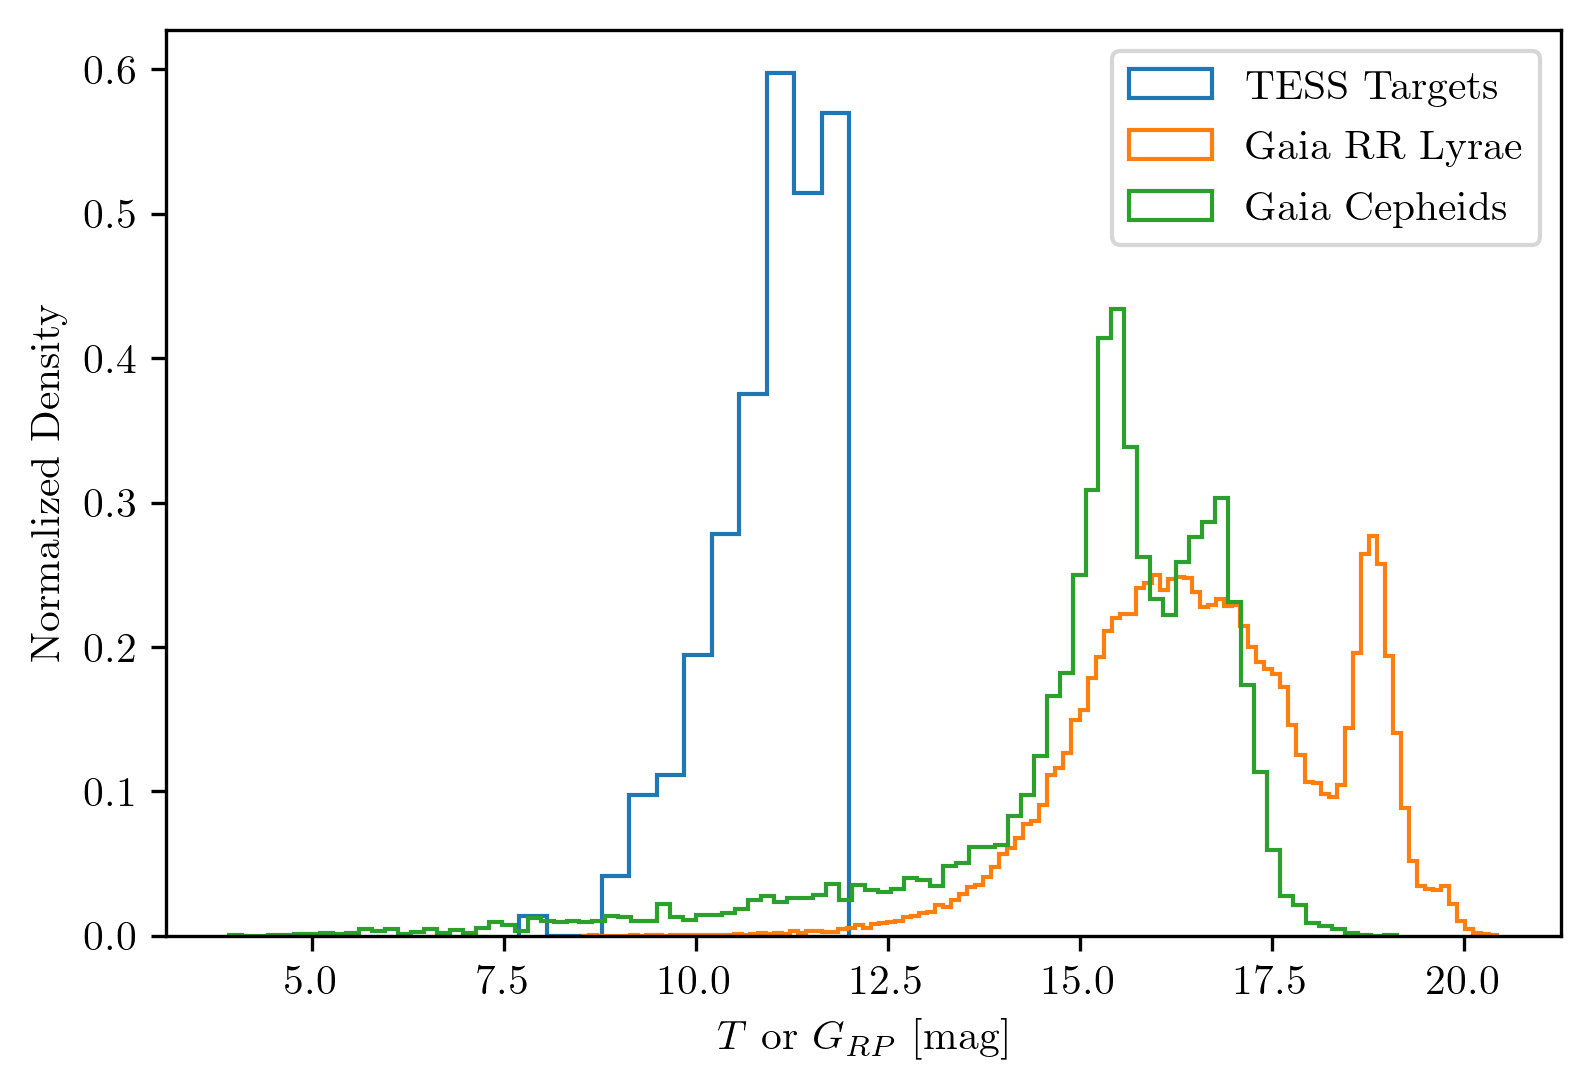

In [5]:
#Looks like the RR Lyrae are in the perfect magnitude range for contaminating our stars!
fig = plt.figure(dpi=300)
plt.hist(merged['Tmag'],bins='auto',histtype='step',density=True,label='TESS Targets')
plt.hist(GaiaRRL['phot_rp_mean_mag'],bins='auto',histtype='step',density=True,label='Gaia RR Lyrae')
plt.hist(GaiaCep['phot_rp_mean_mag'],bins='auto',histtype='step',density=True,label='Gaia Cepheids')
plt.xlabel('$T$ or $G_{RP}$ [mag]')
plt.ylabel('Normalized Density')
plt.legend()

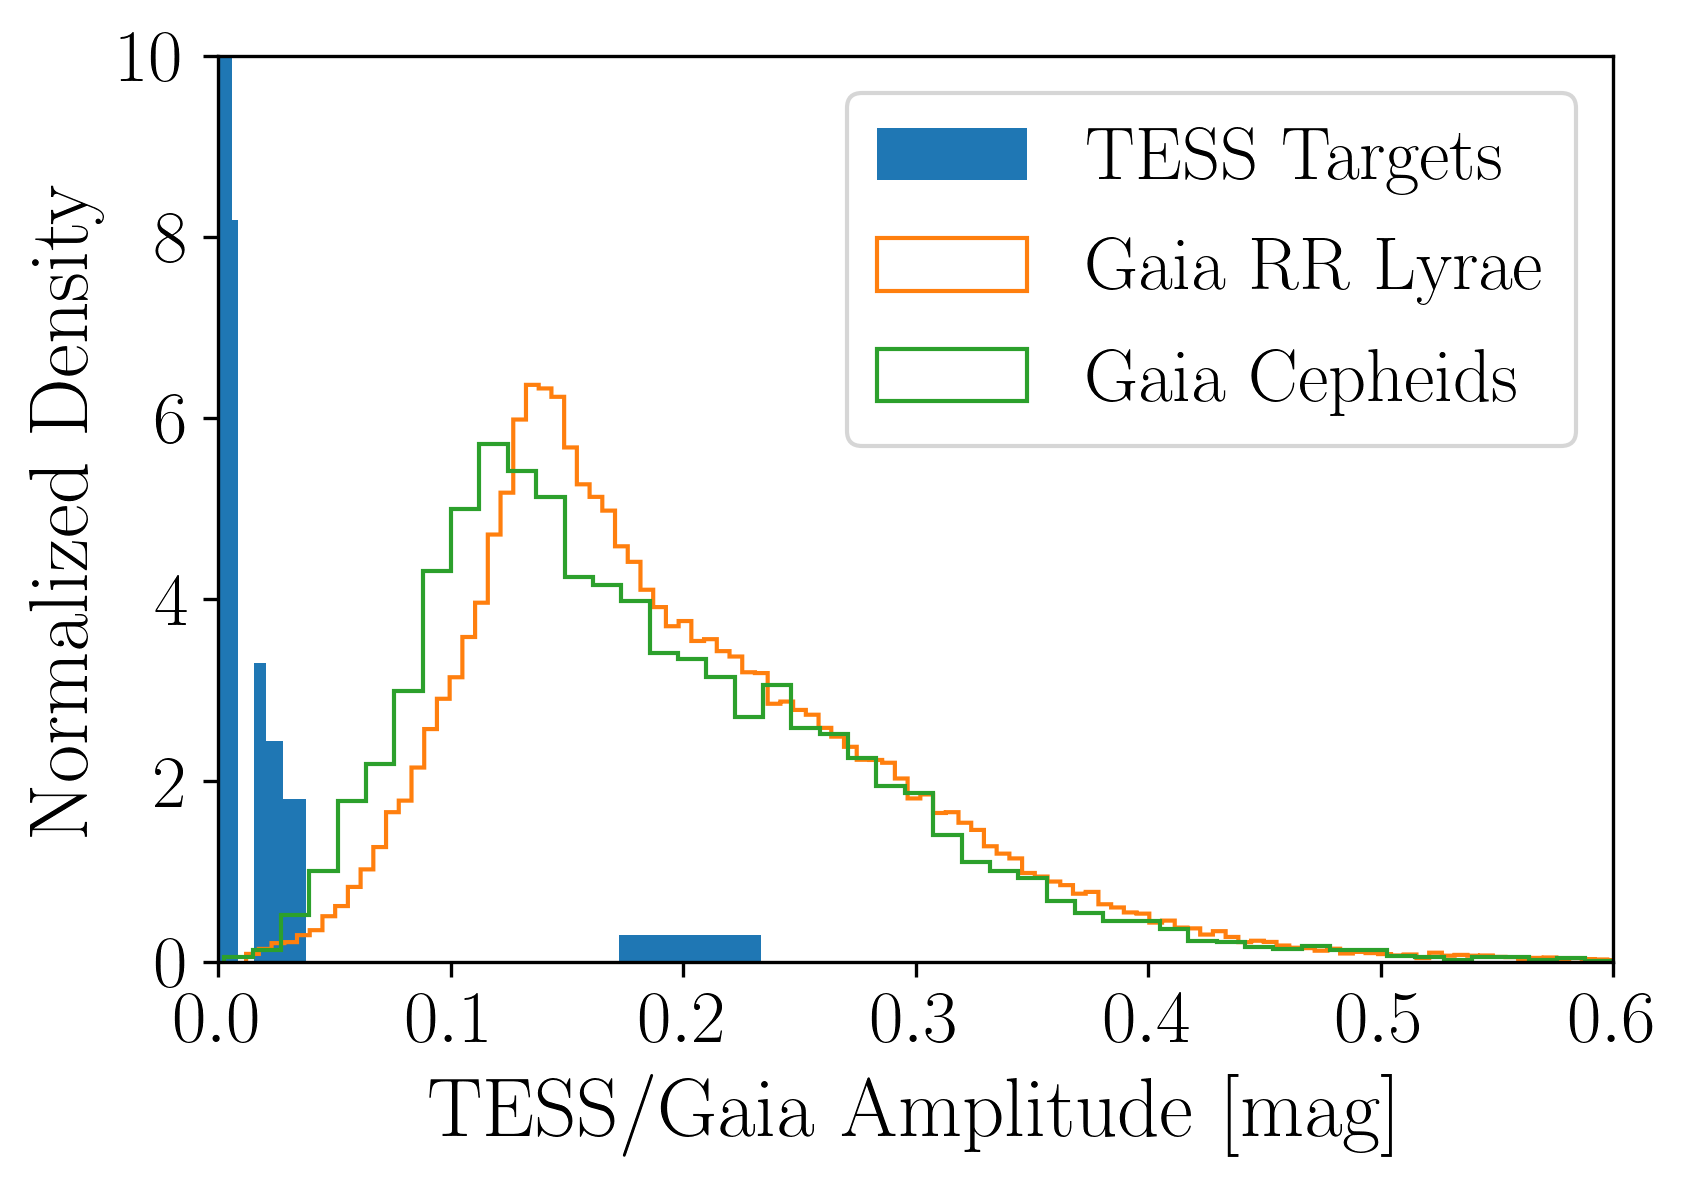

In [6]:
#Looks like the RR Lyrae are in the perfect magnitude range for contaminating our stars!
fig = plt.figure(dpi=300)
plt.hist(merged['highest_amp'],bins=np.logspace(-3,-0.5,20),density=True,label='TESS Targets')
plt.hist(GaiaRRL['peak_to_peak_rp']/2.0,bins='auto',histtype='step',density=True,label='Gaia RR Lyrae')
plt.hist(GaiaCep['peak_to_peak_rp']/2.0,bins='auto',histtype='step',density=True,label='Gaia Cepheids')
plt.xlabel('TESS/Gaia Amplitude [mag]',fontsize=20)
plt.ylabel('Normalized Density',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.ylim(0,10)
plt.xlim(0,0.6)

plt.savefig('../plots/amplitude_histogram.pdf',bbox_inches='tight')

In [7]:
#Let's crossmatch and see if there are any matches within 100" that are also TESS pulsators
tess = SkyCoord(ra=merged['RA'],dec=merged['Dec'], unit=u.degree)
gaia = SkyCoord(ra=GaiaPulse['ra'],dec=GaiaPulse['dec'], unit=u.degree)

idx, d2d, d3d = tess.match_to_catalog_sky(gaia)

Pulse_close = d2d <= 100*u.arcsecond
is_pulsator = merged['highest_amp'] > 0
idx_close = idx[Pulse_close & is_pulsator]
tess_close = merged[Pulse_close & is_pulsator]
gaia_close = GaiaPulse.iloc[idx_close]

print(f'I found {len(tess_close)} TESS targets with nearby RR Lyrae/Cepheids!')

I found 59 TESS targets with nearby RR Lyrae/Cepheids!


Ok, so we observe a star with magnitude $T$ that varies with amplitude $Y$. But it's actually contaminated by a star that's a flux ratio $R$ times fainter than the main star, corresponding to a magnitude difference of 

$\Delta T = -2.5 \log R$,

pulsating with an actual amplitude of $X$. 

The intrinsic and observed amplitudes are related by a factor of $R$:

$Y = R X$.

So if we observe $Y$, this corresponds to a star of magnitude $T+\Delta T$ pulsating with an amplitude of $-2.5\log(1+Y/R)$ 

So we can see that for this example, it's not likely to be a RR Lyrae.

In [8]:
# Let's automatically do it for every star
from tqdm.notebook import tqdm

tics = []
likely_rr = []
likely_cep = []

for tic,star in tqdm(merged.iterrows(), total=len(merged)):
    
    tics.append(tic)
    
    pos = tic == tess_close.index #check if TIC in catalog of close ones
    
    if np.any(pos):

        T0 = star['Tmag']
        observed = star['highest_amp']
        
        pulse = gaia_close[pos].iloc[0]

        T1s = np.linspace(T0-1,GaiaPulse['phot_rp_mean_mag'].max(),3000)
        dTs = T1s-T0

        R = np.power(10.0,-dTs/2.5)
        real = 2.5*np.log10(1.0 + observed/R)
            
        T1_idx = np.argmin(np.abs(T1s - pulse['phot_rp_mean_mag']))
        
        rrcep = np.abs(real[T1_idx] - pulse['peak_to_peak_rp']/2.0) <= pulse['peak_to_peak_rp_error']/2.0
        if rrcep & (pulse['Class'] == 'RRLyrae'):
            likely_rr.append(True)
            likely_cep.append(False)
        elif rrcep & (pulse['Class'] == 'Cepheid'):
            likely_rr.append(False)
            likely_cep.append(True)
        else:
            likely_rr.append(False)
            likely_cep.append(False)
                
    else:
        likely_rr.append(False)
        likely_cep.append(False)
        

rrcep_df = pd.DataFrame({'LikelyRR':np.array(likely_rr),'LikelyCep':np.array(likely_cep)},index=tics)

  0%|          | 0/201 [00:00<?, ?it/s]

Text(0, 0.5, 'Amplitude of Variable [mag]')

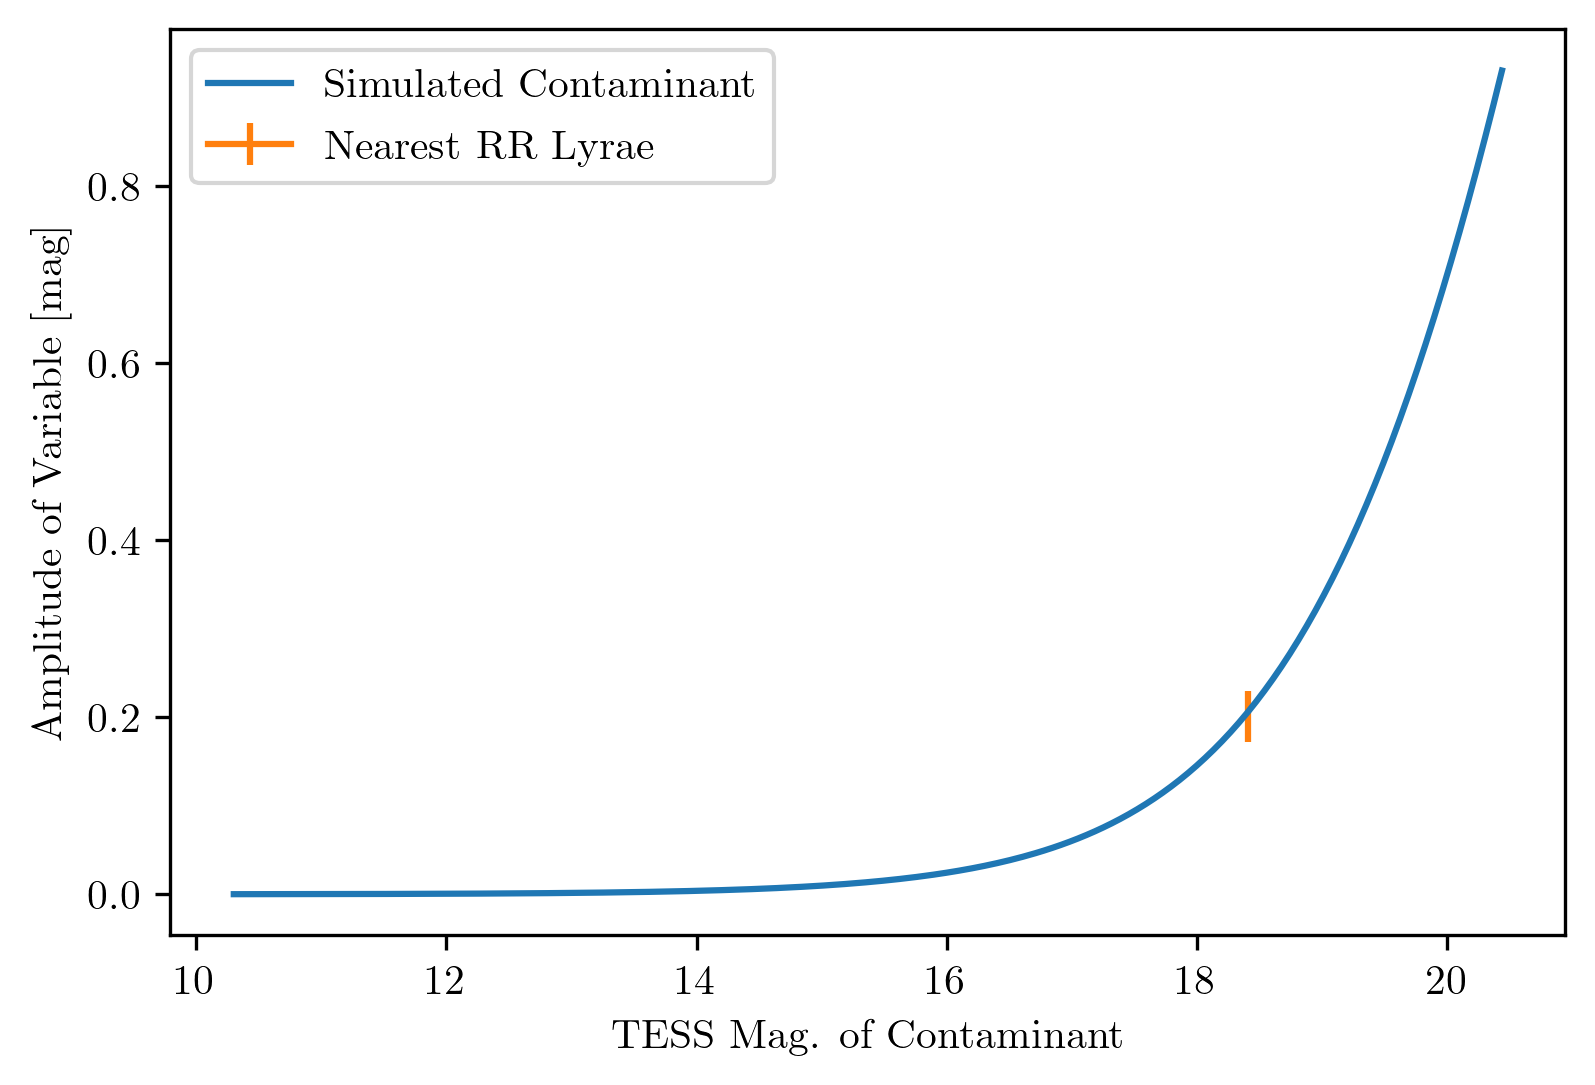

In [9]:
trythis = rrcep_df[rrcep_df['LikelyRR']].index[0]
example = tess_close.loc[trythis]
tryidx = tess_close.index == trythis
example_rr = gaia_close[tryidx]

observed = example['highest_amp']
T0 = example['Tmag']

T1s = np.linspace(T0,GaiaRRL['phot_rp_mean_mag'].max(),300)
dTs = T1s-T0

R = np.power(10.0,-dTs/2.5)
real = 2.5*np.log10(1.0 + observed/R)

fig = plt.figure(dpi=300)

plt.plot(T1s,real,label='Simulated Contaminant')

plt.errorbar(example_rr['phot_rp_mean_mag'],example_rr['peak_to_peak_rp']/2.0,yerr=example_rr['peak_to_peak_rp_error']/2.0,label='Nearest RR Lyrae')

plt.legend()

plt.xlabel('TESS Mag. of Contaminant')
plt.ylabel('Amplitude of Variable [mag]')

(0.001, 100)

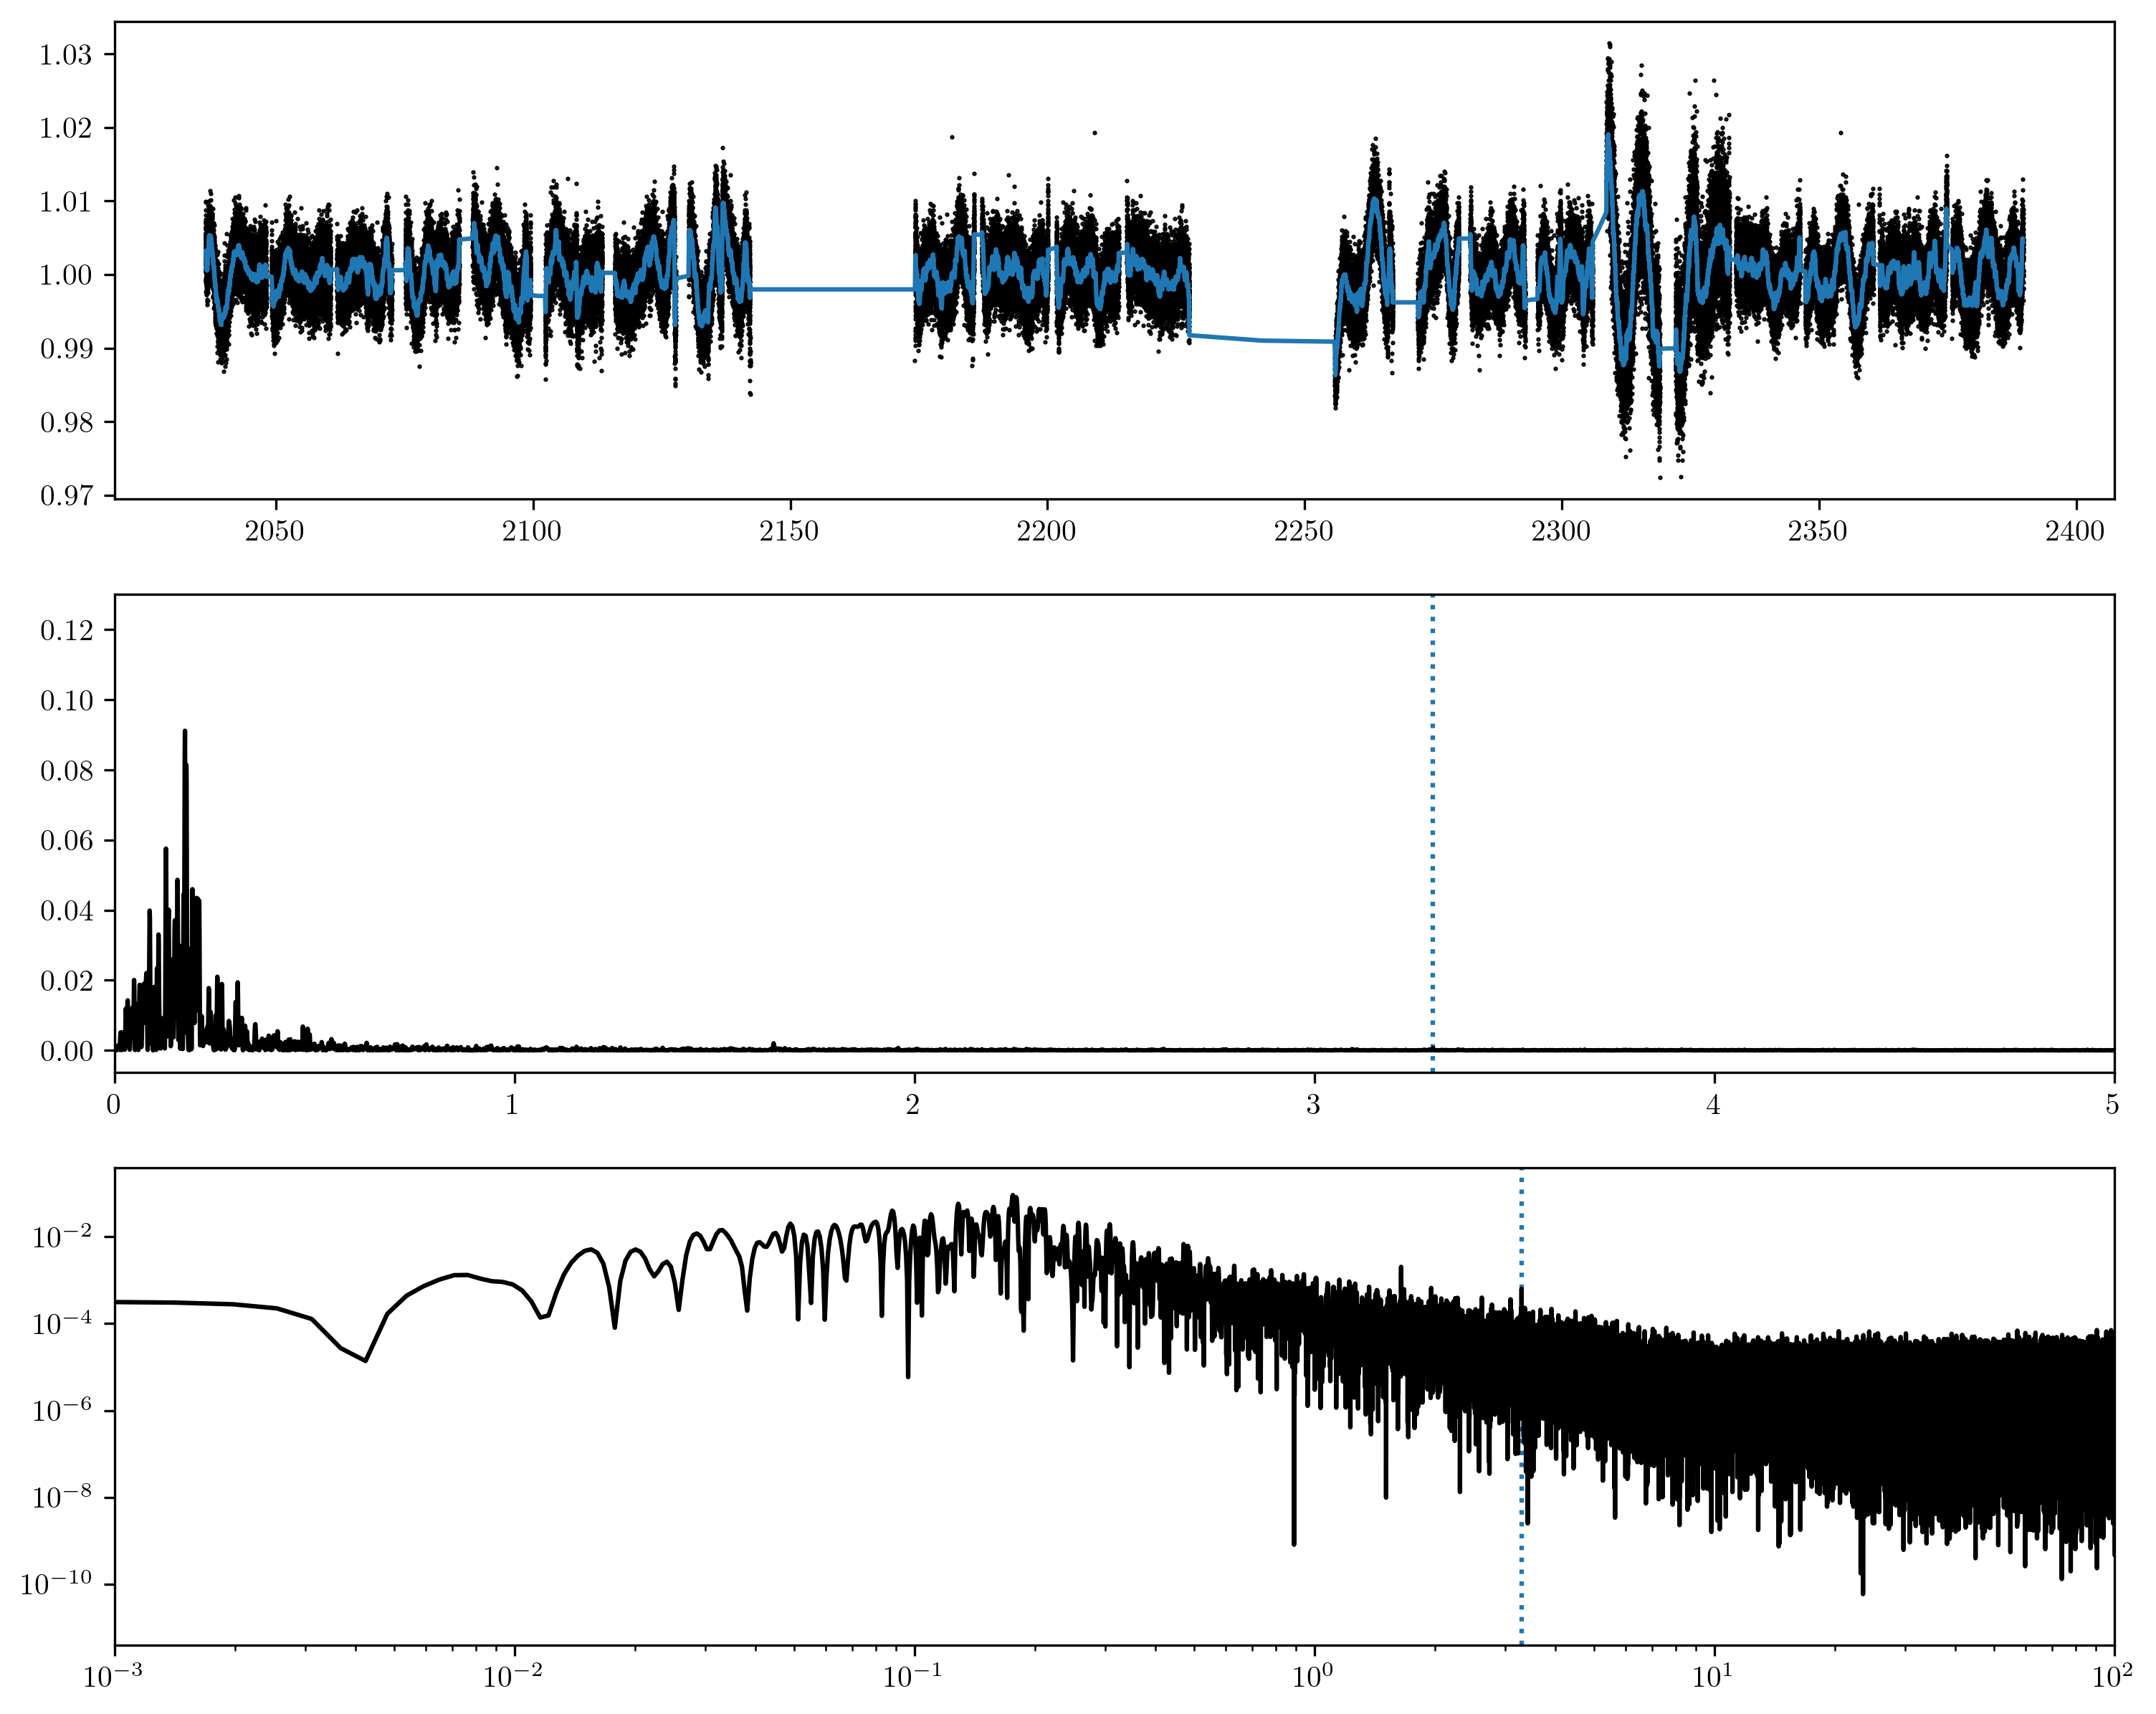

In [30]:
from TESStools import lc_extract, get_lc_from_id
lc, lc_smooth = lc_extract(get_lc_from_id(trythis), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

fig, ax = plt.subplots(3,1,figsize=(12,10),dpi=300)
ax[0].scatter(time, flux, c='k', marker='.', s=1)
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'])

from astropy.timeseries import LombScargle
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower()
ax[1].axvline(x=merged.loc[trythis]['f0'],ls=':')
ax[1].plot(freq, power,c='k')
ax[1].set_xlim(0,5)

ax[2].axvline(x=merged.loc[trythis]['f0'],ls=':')
ax[2].loglog(freq, power,c='k')
ax[2].set_xlim(1e-3,100)

In [25]:
merged.loc[trythis]['f0']

3.2968027456153024

  0%|          | 0/201 [00:00<?, ?it/s]

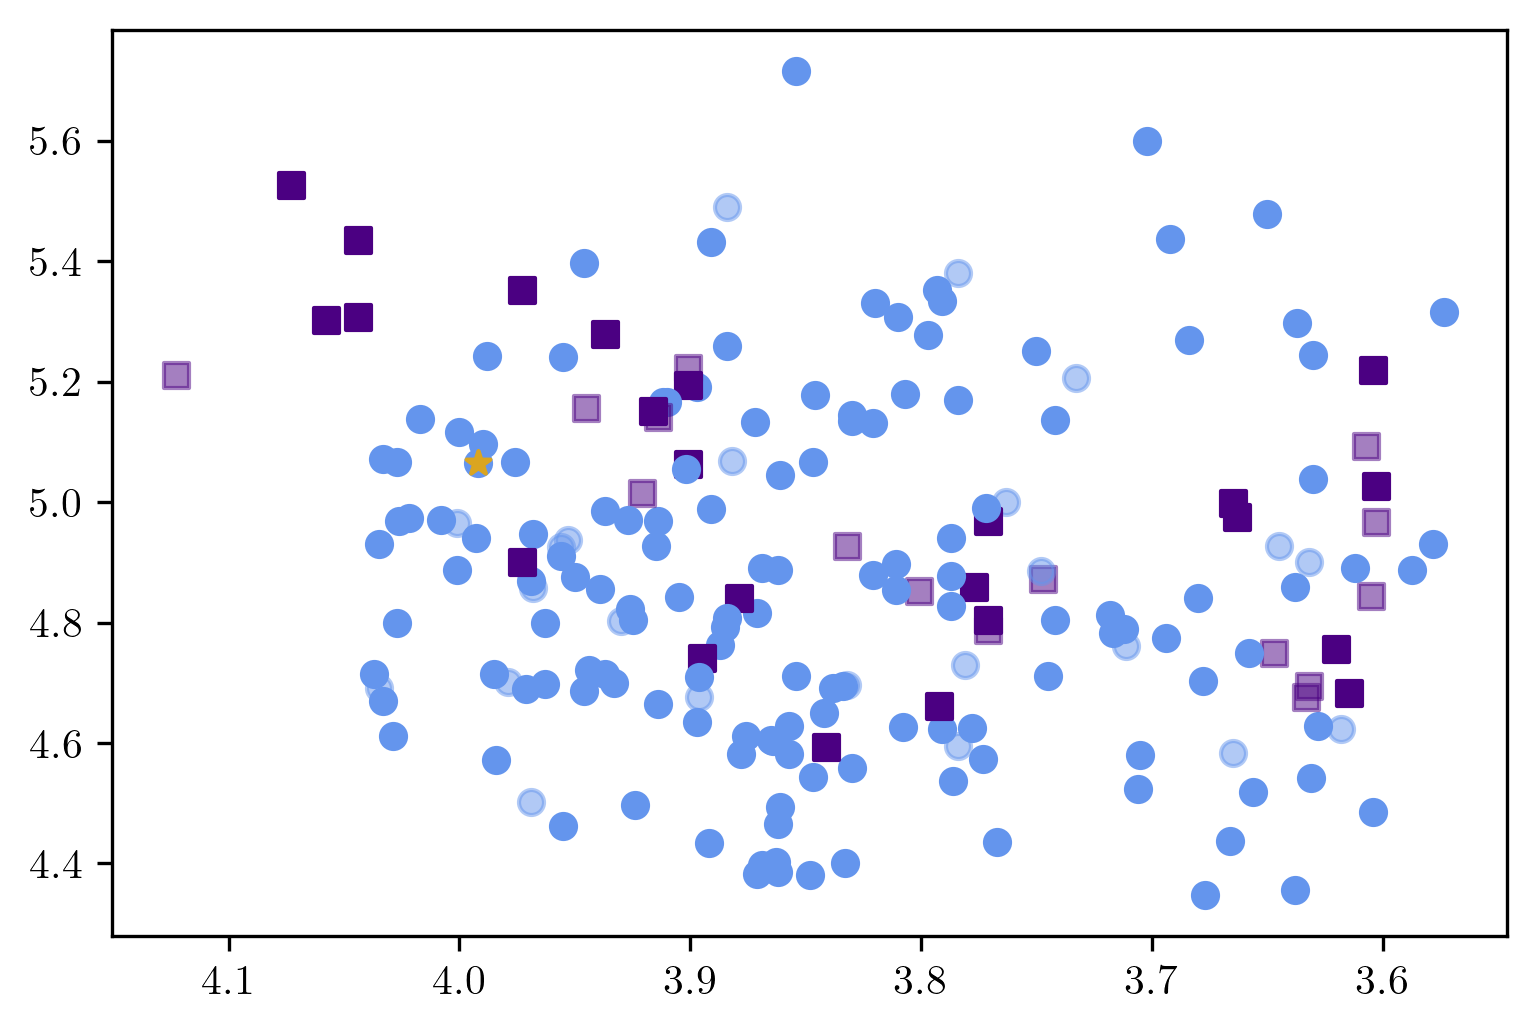

In [12]:
fig = plt.figure(dpi=300)
for tic,star in tqdm(merged.iterrows(), total=len(merged)):
    if star['Gal'] == 'LMC':
        m = 'o'
        c = 'cornflowerblue'
    else:
        m = 's'
        c = 'indigo'
        
    if star['highest_amp'] > 0:
        alpha = 1.0
    else:
        alpha = 0.5
        
    plt.scatter(star['teff'],star['lum'],marker=m,c=c,alpha=alpha)
    
    if rrcep_df.loc[tic]['LikelyRR'] or rrcep_df.loc[tic]['LikelyCep']:
        plt.scatter(star['teff'],star['lum'],marker='*',c='goldenrod')
        
plt.gca().invert_xaxis()

In [13]:
rrcep_df.to_csv('likelyRRCep.csv')